# Statistical inference over human and model behavioral performance

**The purpose of this notebook is to:** 
* Visualize human and model prediction accuracy (proportion correct)
* Visualize average-human and model agreement (RMSE)
* Visualize human-human and model-human agreement (Cohen's kappa)
* Compare performance between models

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)
* Running `./summarize_human_model_behavior.ipynb` (PUBLIC USE)

### Load packages

In [1]:
suppressMessages(suppressWarnings(suppressPackageStartupMessages({library(tidyverse)
library(ggthemes)
library(lme4)
library(lmerTest)
library(brms)
library(broom.mixed)
library(tidyboot)                
require('MuMIn')
})))

In [2]:
A = read_csv('../results/csv/summary/model_human_accuracies.csv')
# A = read_csv('../results/csv/models/allModels_results.csv')
AH = read_csv('../results/csv/summary/human_accuracy_by_scenario.csv')
K = read_csv('../results/csv/summary/model_human_CohensK.csv')

## preprocessing
A <- A %>%
    dplyr::rename('model_kind'='Model Kind', 
                  'encoder_training_dataset_type'='Encoder Training Dataset Type',
                  'dynamics_training_dataset_type'='Dynamics Training Dataset Type',
                  'readout_training_data_type'='Readout Train Data Type', 
                  'readout_type'='Readout Type',
                  'visual_encoder_architecture' = 'Visual encoder architecture',
                  'dynamics_model_architecture' = 'Dynamics model architecture') %>%
    mutate(dynamics_model_architecture = factor(dynamics_model_architecture)) %>%
#     left_join(AH, by='scenario') %>% 
    group_by(model_kind) %>%
    mutate(avg_model_correct = mean(model_correct)) %>%
    ungroup()


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  ratio = col_double(),
  diff = col_double(),
  human_correct = col_double(),
  model_correct = col_double(),
  `Encoder Pre-training Seed` = col_logical(),
  `Encoder Training Seed` = col_double(),
  `Dynamics Training Seed` = col_double(),
  ObjectCentric = col_logical(),
  Supervised = col_logical(),
  SelfSupervisedLossSelfSupervisedLoss = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  agent = col_character(),
  scenario = col_character(),
  obs_mean = col_double(),
  boot_mean = col_double(),
  ci_lb = col_double(),
  ci_ub = col_double(),
  pct_2.5 = col_double(),
  pct_97.5 = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  Cohens_k_lb = col_double(),
  Cohens_k_med

## Visualize human and model prediction accuracy (proportion correct)


── Column specification ────────────────────────────────────────────────────────
cols(
  agent = col_character(),
  scenario = col_character(),
  obs_mean = col_double(),
  boot_mean = col_double(),
  ci_lb = col_double(),
  ci_ub = col_double(),
  pct_2.5 = col_double(),
  pct_97.5 = col_double()
)




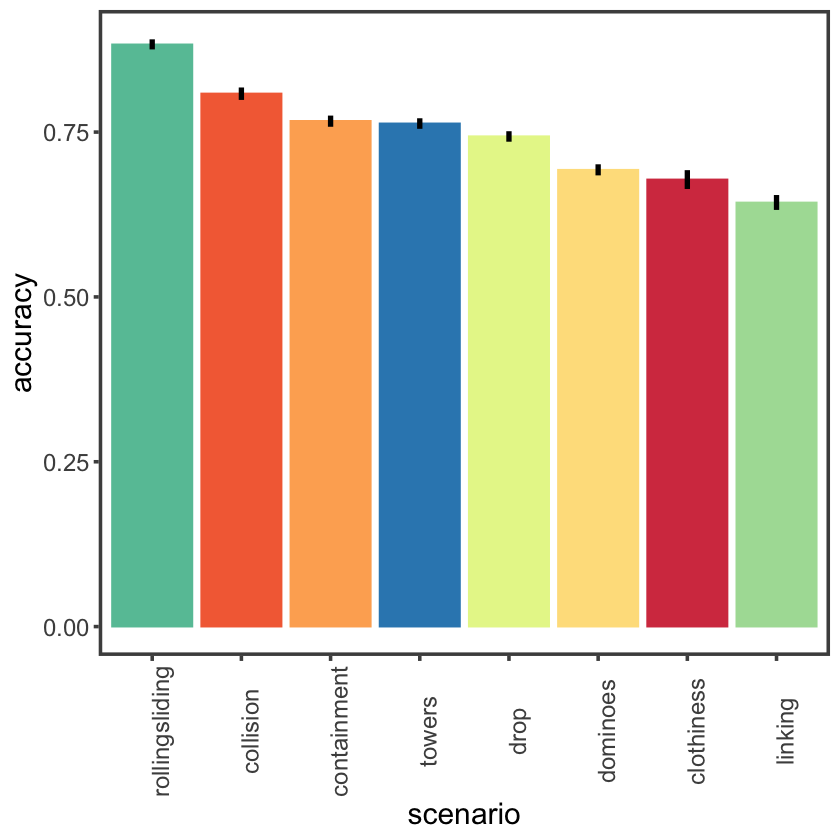

In [3]:
## human accuracy only
d = read_csv('../results/csv/summary/human_accuracy_by_scenario.csv')

## accuracy bar plot with 95% CIs
d %>%
  ggplot(aes(x=reorder(scenario,-obs_mean), y=obs_mean, color=scenario, fill=scenario)) +
  geom_bar(stat='identity') +
  geom_errorbar(aes(ymin=ci_lb, ymax = ci_ub), width = 0, size = 1.5, color='black') + 
    theme_few() +
    xlab('scenario') +
    ylab('accuracy') +
    theme(text = element_text(size=18), 
          element_line(size=1), 
          element_rect(size=2, color="#00000"),
          axis.text.x = element_text(angle=90)) +
    theme(legend.position = "none") +
    scale_fill_brewer(palette="Spectral") + scale_color_brewer(palette="Spectral")

ggsave('../results/plots/human_accuracy_across_scenarios.pdf', width=12, height = 18, units='cm')

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”
Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 116 rows containing missing values (geom_point).”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”
Warning message:
“The shape palette 

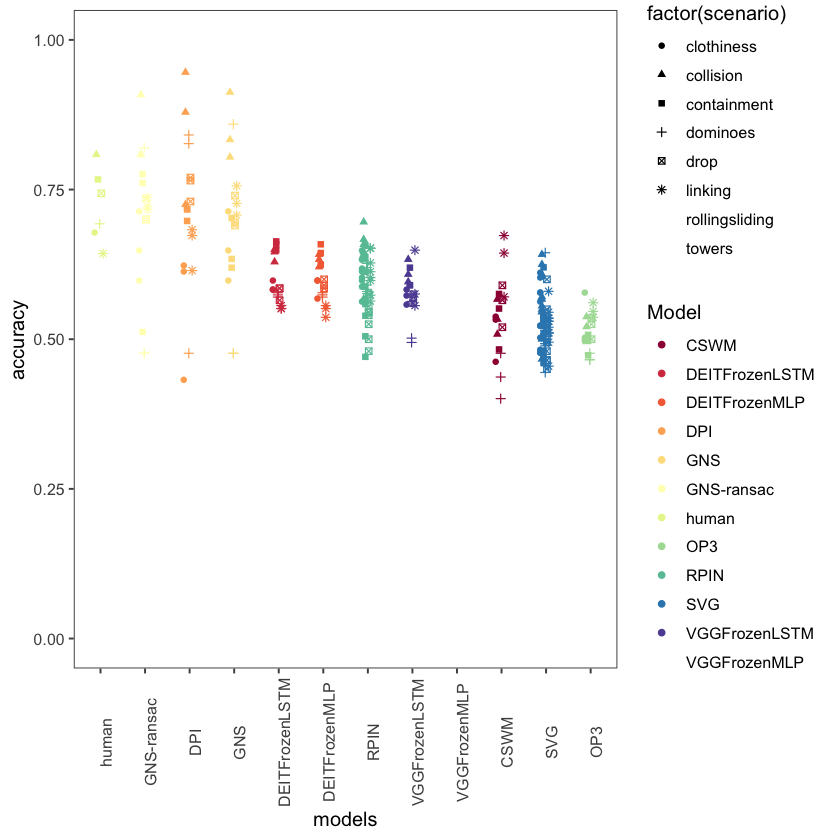

In [4]:
## human model accuracy comparison (MAIN FIGURE)
A %>%
    filter(readout_type %in% c('B')) %>%
    select(Model, model_correct, dynamics_training_dataset_type, readout_type, scenario) %>%
    bind_rows(AH %>%  dplyr::rename(Model=agent, model_correct = obs_mean) %>% select(Model, model_correct, scenario)) %>%
    ggplot(aes(x=reorder(Model,-model_correct), y=model_correct,
               color=Model, fill=Model, shape = factor(scenario))) +
    geom_point(stat='identity', position=position_dodge(0.3)) +  
#     geom_hline(aes(yintercept = human_correct)) +
#     geom_rect(aes(ymin = ci_lb, ymax = ci_ub, xmin = -Inf, xmax = Inf), color=NA, fill = 'gray', alpha = 0.05) +
#     facet_grid(rows=vars(scenario), cols=vars(dynamics_training_dataset_type)) +
    theme_few() +
    theme(axis.text.x = element_text(angle=90)) +
    xlab('models') +
    ylab('accuracy') +
    ylim(0,1) +
    scale_fill_brewer(palette="Spectral") + scale_color_brewer(palette="Spectral")

ggsave('../results/plots/human_model_accuracy_across_scenarios.pdf', width=36, height = 36, units='cm')

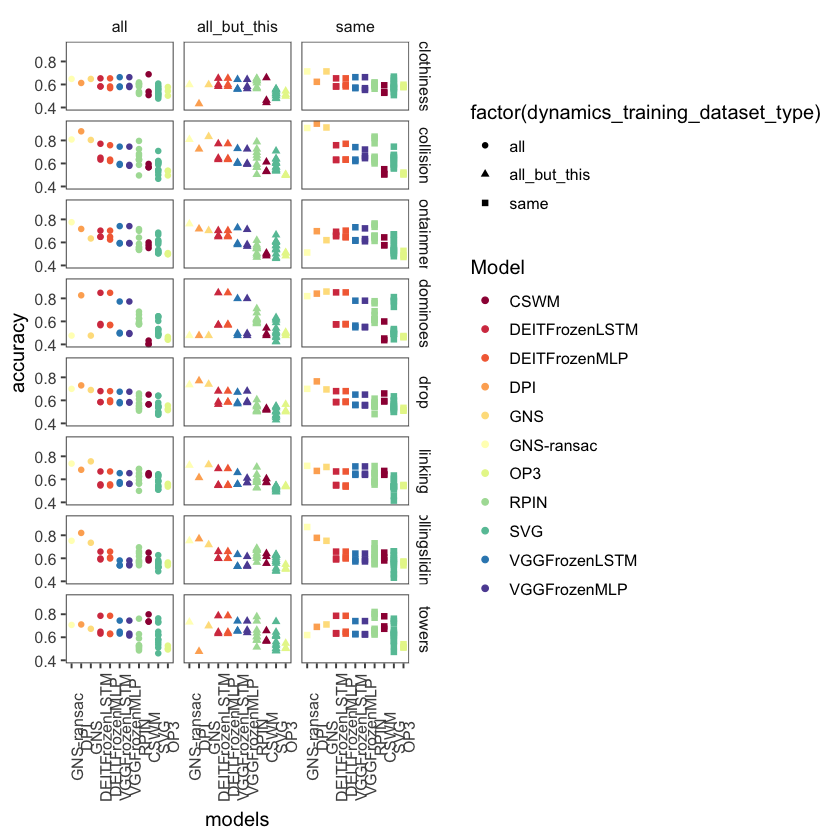

In [5]:
## human model accuracy comparison by dynamics training data
A %>%
    filter(readout_type %in% c('A','B','C')) %>%
    ggplot(aes(x=reorder(Model,-model_correct), y=model_correct,
               color=Model, fill=Model, shape = factor(dynamics_training_dataset_type))) +
    geom_point(stat='identity', position=position_dodge(0.3)) +  
    #geom_hline(aes(yintercept = human_correct)) +
#     geom_rect(aes(ymin = ci_lb, ymax = ci_ub, xmin = -Inf, xmax = Inf), color=NA, fill = 'gray', alpha = 0.05) +
    facet_grid(rows=vars(scenario), cols=vars(dynamics_training_dataset_type)) +
    theme_few() +
    theme(axis.text.x = element_text(angle=90)) +
    xlab('models') +
    ylab('accuracy') +
    scale_fill_brewer(palette="Spectral") + scale_color_brewer(palette="Spectral")

ggsave('../results/plots/human_model_accuracy_across_scenarios_by_dynamicsTraining.pdf', width=36, height = 36, units='cm')

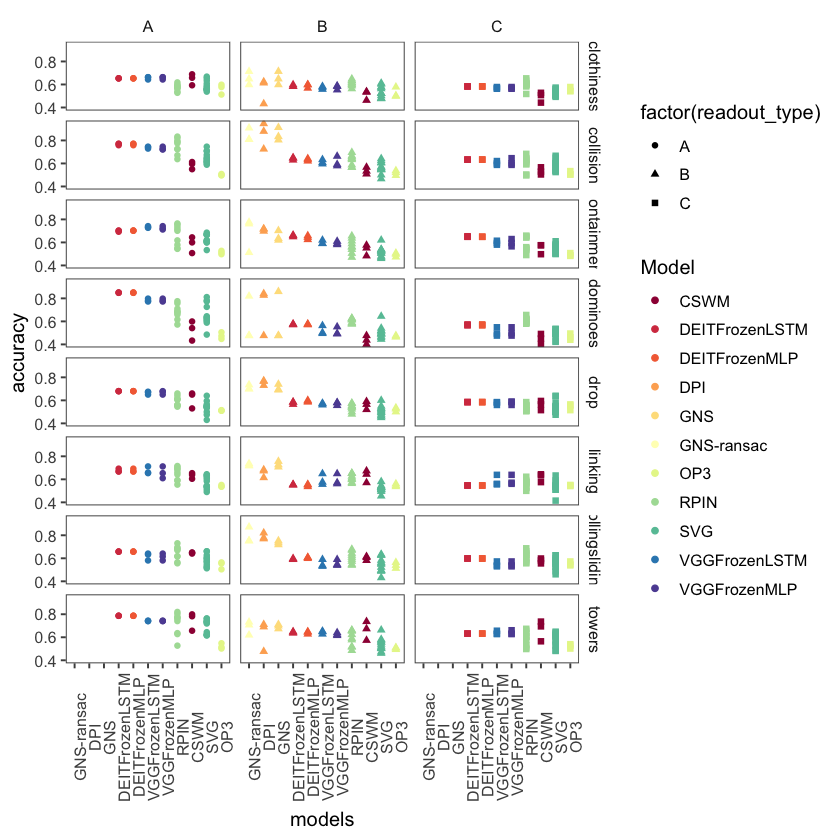

In [6]:
## A = "full sequence"
## B = "initial + predicted"
## C = "initial only"
## human model accuracy comparison by readout type

A %>%
    filter(readout_type %in% c('A','B','C')) %>%
    ggplot(aes(x=reorder(Model,-model_correct), y=model_correct,
               color=Model, fill=Model, shape = factor(readout_type))) +
    geom_point(stat='identity', position=position_dodge(0.3)) +  
    #geom_hline(aes(yintercept = human_correct)) +
#     geom_rect(aes(ymin = ci_lb, ymax = ci_ub, xmin = -Inf, xmax = Inf), color=NA, fill = 'gray', alpha = 0.05) +
    facet_grid(rows=vars(scenario), cols=vars(readout_type)) +
    theme_few() +
    theme(axis.text.x = element_text(angle=90)) +
    xlab('models') +
    ylab('accuracy') +
    scale_fill_brewer(palette="Spectral") + scale_color_brewer(palette="Spectral")

ggsave('../results/plots/human_model_accuracy_across_scenarios_by_readoutType.pdf', width=36, height = 36, units='cm')

## Visualize average-human and model agreement (RMSE)

In [7]:
## TODO

## Visualize human-human and model-human agreement (Cohen's kappa)

In [8]:
## TODO

## Comparing performance between models

* Question 1: Visual encoder architecture (ConvNet [SVG/VGGFrozenLSTM] vs. transformer [DEITFrozenLSTM] … DEITFrozenMLP vs. SVG/VGGFrozenMLP)
* Question 2: Dynamics model RNN vs. MLP (LSTM vs. MLP for above)
* Question 3: Among unsupervised models, object-centric vs. non-object-centric
        * {CSWM, OP3} vs. {SVG}
* Question 4: Latent vs. pixel reconstruction loss
        * CSWM vs. OP3
* Question 5: RPIN vs. CSWM/OP3 (“supervised explicit object-centric” vs. “unsupervised implicit object-centric”)
* Question 6: DPI vs GNS and GNS-RANSAC (DPI is object-centric, whereas GNS is not? and GNS-RANSAC is somewhere in between.)
* Question 7: GNS vs. GNS-RANSAC
* Question 8: Particle models (GNS, GNS-RANSAC, DPI) vs. humans
    - Estimate difference between particle model accuracy and human accuracy
        ```
        model_correct ~ particleOrHuman + (1 | scenario) + (1 | training_data) + (1 | readout_type)
        ```
    - Estimate similarity between model responses and human responses
    
* Question 9: Particle models  (GNS, GNS-RANSAC, DPI) vs. remaining vision models
* Question 10: Among TDW-trained vision models, are supervised (RPIN) better than unsupervised (SVG, CSWM, OP3)
* Question 11: Posgit chsibly useful to look at how well visual encoders do alone (e.g. Readout type A vs. humans)
* Question 12: For pretrained encoder vision models (frozen), is readout B any better than readout C? If not, then none of the vision models are actually getting anything out of learning dynamics
* Question 13: For end2end vision models (CSWM, OP3, SVG, RPIN), is readout B any better than readout C? If not, then none of the vision models are actually getting anything out of learning dynamics
* Question 14: Impact of dynamics training data variability on accuracy
* Question 15: is the supervised object-centric vision model (TDW training only) better than the best unsupervised? RPIN vs CSWM
* Question 16: if possible, same comparison above but on Cohen's kappa? (nice-to-have)
* Question 17: Is ImageNet pretraining better than object-centric TDW pretraining, assuming a CNN encoder? (VGGfrozen-MLP,LSTM ) vs (CSWM,RPIN)
* Question 18: If the three particle models DPI, GNS, GNS-R aren't distinguishable, I would like to better understand why. Is this because GNS and GNS-R are being pulled way down by a single outlier (Dominoes)? I.e. does the result change if you exclude dominoes?
* Question 19: Same as (4) but with Cohen's kappa (nice-to-have)
* Question 20: Is readout type A (fully observed the movie) significantly better than readout type B or C (initial observations with/without simulation); best to do this separately for the "frozen" models (VGGfrozen, DEITfrozen, etc.) and for the TDW-only trained models (SVG, OP3, CSWM, RPIN)

**Dimensions:** 
* “Visual encoder architecture” : [“ConvNet” “Transformer” “Neither”]
* “Dynamics model architecture” : [“LSTM”, “MLP”, “Neither”]
* “ObjectCentric”: [TRUE, FALSE, NA]
* “Supervised”: [TRUE, FALSE]
* “SelfSupervisedLoss”: [“latent”, “pixel”, “NA”]

## Q1: Visual encoder architecture (ConvNet vs. transformer)

In [9]:
## Comparison 1: Visual encoder architecture (ConvNet [SVG/VGGFrozenLSTM] vs. transformer [DEITFrozenLSTM] … DEITFrozenMLP vs. SVG/VGGFrozenMLP)
Q1 <- A %>% 
        filter(visual_encoder_architecture %in% c('ConvNet','Transformer')) %>%
        filter(readout_type %in% c('A','B','C')) 

In [10]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q1)
M1 <- lmer(model_correct ~ visual_encoder_architecture + (1 | scenario)  + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q1)
summary(M1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ visual_encoder_architecture + (1 | scenario) +  
    (1 | readout_type) + (1 | dynamics_training_dataset_type)
   Data: Q1

REML criterion at convergence: -1789.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3436 -0.5445 -0.0509  0.5039  3.5849 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0007253 0.02693 
 readout_type                   (Intercept) 0.0032009 0.05658 
 dynamics_training_dataset_type (Intercept) 0.0001295 0.01138 
 Residual                                   0.0023774 0.04876 
Number of obs: 576, groups:  
scenario, 8; readout_type, 3; dynamics_training_dataset_type, 3

Fixed effects:
                                        Estimate Std. Error        df t value
(Intercept)                            5.636e-01  3.477e-02 2.538e+00   16.21
visual_encoder_architectur

Transformer architectures outperform convnet architectures.

In [11]:
## model comparison relative to null model
anova(M0,M1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,5,-1571.639,-1549.858,790.8194,-1581.639,NA,NA,NA
M1,6,-1791.992,-1765.856,901.9962,-1803.992,222.3536,1,2.773388e-50


Model containing `visual_encoder_architecture` as a predictor outperforms null model without it .

In [12]:
## explained variance
r.squaredGLMM(M1)

Warning message:
“'r.squaredGLMM' now calculates a revised statistic. See the help page.”


R2m,R2c
0.1488425,0.6854477


Showing that your marginal R squared is 0.14 and your conditional R squared is 0.72. 

### Transformer architecture outperforms ConvNet architecture: $b=6.670e-02,t(925)=21.2, p<0.001$

## Q2: Dynamics model RNN vs. MLP (LSTM vs. MLP for above)

In [13]:
## Comparison 2
Q2 <- A %>% 
        filter(dynamics_model_architecture %in% c('LSTM','MLP')) %>%
        mutate(dynamics_model_architecture = factor(dynamics_model_architecture)) %>%
        filter(readout_type %in% c('A','B','C'))   

In [14]:
Q2 %>% 
    group_by(dynamics_model_architecture, Model) %>%
    summarise(mean(model_correct))

`summarise()` has grouped output by 'dynamics_model_architecture'. You can override using the `.groups` argument.



dynamics_model_architecture,Model,mean(model_correct)
<fct>,<chr>,<dbl>
LSTM,DEITFrozenLSTM,0.6414327
LSTM,VGGFrozenLSTM,0.6206286
MLP,DEITFrozenMLP,0.6411965
MLP,VGGFrozenMLP,0.6191530


In [15]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q2)
M2 <- lmer(model_correct ~ dynamics_model_architecture + (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q2)
summary(M2)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ dynamics_model_architecture + (1 | scenario) +  
    (1 | readout_type) + (1 | dynamics_training_dataset_type)
   Data: Q2

REML criterion at convergence: -1002.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9413 -0.5383 -0.0882  0.4646  3.5711 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 9.860e-04 0.031400
 readout_type                   (Intercept) 4.761e-03 0.068997
 dynamics_training_dataset_type (Intercept) 2.167e-05 0.004656
 Residual                                   1.499e-03 0.038716
Number of obs: 288, groups:  
scenario, 8; readout_type, 3; dynamics_training_dataset_type, 3

Fixed effects:
                                 Estimate Std. Error         df t value
(Intercept)                     6.310e-01  4.157e-02  2.351e+00  15.181
dynamics_model_architectureMLP -8.559e

### Recurrence (LSTM) does not outperform MLP:
```
Fixed effects:
                                 Estimate Std. Error         df t value
(Intercept)                     6.310e-01  4.157e-02  2.351e+00  15.181
dynamics_model_architectureMLP -8.559e-04  4.563e-03  2.750e+02  -0.188
                               Pr(>|t|)   
(Intercept)                     0.00212 **
dynamics_model_architectureMLP  0.85134  
```

In [16]:
anova(M0,M2)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,5,-1006.281,-987.9660,508.1404,-1016.281,NA,NA,NA
M2,6,-1004.316,-982.3383,508.1580,-1016.316,0.03531182,1,0.8509438


In [17]:
## explained variance
r.squaredGLMM(M2)

R2m,R2c
2.528705e-05,0.7937494


## Q3:  Among unsupervised models, object-centric vs. non-object-centric
{CSWM, OP3} vs. {SVG}

In [18]:
## Comparison 3
Q3 <- A %>% 
        filter(Supervised==FALSE) %>%
        filter(ObjectCentric %in% c(TRUE,FALSE)) %>%
        filter(readout_type %in% c('A','B','C'))   

In [19]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q3)
M3 <- lmer(model_correct ~ ObjectCentric + (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q3)
summary(M3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ ObjectCentric + (1 | scenario) + (1 | readout_type) +  
    (1 | dynamics_training_dataset_type)
   Data: Q3

REML criterion at convergence: -1187.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5486 -0.6237 -0.0523  0.5884  3.8256 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0005165 0.02273 
 readout_type                   (Intercept) 0.0012930 0.03596 
 dynamics_training_dataset_type (Intercept) 0.0002776 0.01666 
 Residual                                   0.0033753 0.05810 
Number of obs: 432, groups:  
scenario, 8; readout_type, 3; dynamics_training_dataset_type, 3

Fixed effects:
                   Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)         0.56358    0.02449   3.52503  23.012 5.72e-05 ***
ObjectCentricTRUE  -0.01415    0.00593 419.00000  -2.386

### ObjectCentric representations better than non-object centric: $b=-0.0145 ,t(635)=-3.154, p=0.0017$

In [20]:
anova(M0,M3)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,5,-1186.045,-1165.703,598.0225,-1196.045,NA,NA,NA
M3,6,-1189.711,-1165.301,600.8556,-1201.711,5.666211,1,0.01729477


In [21]:
## explained variance
r.squaredGLMM(M3)

R2m,R2c
0.008093855,0.3870743


## Q4: Latent vs. pixel reconstruction loss
CSWM vs. OP3

In [22]:
## Comparison 4
Q4 <- A %>% 
        filter(Supervised==FALSE) %>%
        filter(ObjectCentric %in% c(TRUE,FALSE)) %>%
        filter(Model %in% c('CSWM','OP3')) %>%
        filter(readout_type %in% c('A','B','C'))   

In [23]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q4)
M4 <- lmer(model_correct ~ Model + (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q4)
summary(M4)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ Model + (1 | scenario) + (1 | readout_type) +  
    (1 | dynamics_training_dataset_type)
   Data: Q4

REML criterion at convergence: -433.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.42972 -0.60811 -0.04023  0.52845  3.10881 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0015977 0.03997 
 readout_type                   (Intercept) 0.0003301 0.01817 
 dynamics_training_dataset_type (Intercept) 0.0002043 0.01429 
 Residual                                   0.0021624 0.04650 
Number of obs: 144, groups:  
scenario, 8; readout_type, 3; dynamics_training_dataset_type, 3

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   0.57897    0.02020   9.31379  28.668 2.11e-10 ***
ModelOP3     -0.05908    0.00775 130.99999  -7.623 4.45e-12 ***
---

### Latent (CSWM) better than pixel reconstruction (OP3) loss:  $b= -0.059 ,t(275)=-11.04, p<2e-16$

In [24]:
anova(M0,M4)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,5,-389.1008,-374.2517,199.5504,-399.1008,NA,NA,NA
M4,6,-435.5205,-417.7016,223.7602,-447.5205,48.4197,1,3.440946e-12


In [25]:
## explained variance
r.squaredGLMM(M4)

R2m,R2c
0.169847,0.5819977


## Q5: RPIN vs. CSWM/OP3 (“supervised explicit object-centric” vs. “unsupervised implicit object-centric”)

In [26]:
## Comparison 3
Q5 <- A %>% 
        filter(Supervised %in% c(TRUE,FALSE)) %>%
        filter(Model %in% c('CSWM','OP3', 'RPIN')) %>%
        filter(readout_type %in% c('A','B','C'))   

In [27]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q5)
M5 <- lmer(model_correct ~ Supervised + (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q5)
summary(M5)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ Supervised + (1 | scenario) + (1 | readout_type) +  
    (1 | dynamics_training_dataset_type)
   Data: Q5

REML criterion at convergence: -948.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.33078 -0.69479 -0.03941  0.62085  3.16217 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0004585 0.02141 
 readout_type                   (Intercept) 0.0009646 0.03106 
 dynamics_training_dataset_type (Intercept) 0.0003097 0.01760 
 Residual                                   0.0037542 0.06127 
Number of obs: 360, groups:  
scenario, 8; readout_type, 3; dynamics_training_dataset_type, 3

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    5.494e-01  2.254e-02 4.151e+00  24.374 1.22e-05 ***
SupervisedTRUE 6.459e-02  6.592e-03 3.470e+02   9.799  <

### Supervised better than unsupervised:  $b= 6.459e-02 ,t(707)=13.99, p<2e-16$

In [28]:
anova(M0,M5)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,5,-867.3823,-847.9517,438.6911,-877.3823,NA,NA,NA
M5,6,-950.3842,-927.0676,481.1921,-962.3842,85.00194,1,2.980721e-20


In [29]:
## explained variance
r.squaredGLMM(M5)

R2m,R2c
0.1546987,0.4216388


## Question 6: DPI vs GNS and GNS-RANSAC (DPI is object-centric, whereas GNS is not? and GNS-RANSAC is somewhere in between.)

In [30]:
Q6 <- A %>% 
        filter(Model %in% c('DPI','GNS', 'GNS-ransac')) %>%
        filter(readout_type %in% c('A','B','C')) %>%
        mutate(isDPI = if_else(Model=='DPI', TRUE, FALSE))

In [31]:
M0 <- lmer(model_correct ~ (1 | scenario)  + (1 | dynamics_training_dataset_type), data=Q6)
M6 <- lmer(model_correct ~ isDPI + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q6)
summary(M6)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ isDPI + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q6

REML criterion at convergence: -120.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.32387 -0.39744  0.08533  0.59404  2.11938 

Random effects:
 Groups                         Name        Variance Std.Dev.
 scenario                       (Intercept) 0.004690 0.06848 
 dynamics_training_dataset_type (Intercept) 0.001072 0.03274 
 Residual                                   0.007524 0.08674 
Number of obs: 72, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 7.070e-01  3.317e-02 6.925e+00  21.313 1.43e-07 ***
isDPITRUE   3.982e-04  2.169e-02 6.100e+01   0.018    0.985    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)


### DPI not better than {GNS, GNS-ransac}:  $b= 3.982e-04 ,t(61)=0.018, p=0.985$

In [32]:
anova(M0,M6)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,4,-123.3077,-114.2011,65.65387,-131.3077,NA,NA,NA
M6,5,-121.3081,-109.9248,65.65404,-131.3081,0.0003420021,1,0.9852453


In [33]:
## explained variance
r.squaredGLMM(M6)

R2m,R2c
2.688904e-06,0.4336703


## Question 7: GNS vs. GNS-RANSAC

In [34]:
Q7 <- A %>% 
        filter(Model %in% c('GNS', 'GNS-ransac')) %>%
        filter(readout_type %in% c('A','B','C')) %>%
        mutate(isRansac = if_else(Model=='GNS-ransac', TRUE, FALSE))

In [35]:
M0 <- lmer(model_correct ~ (1 | scenario)  + (1 | dynamics_training_dataset_type), data=Q7)
M7 <- lmer(model_correct ~ isRansac + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q7)
summary(M7)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ isRansac + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q7

REML criterion at convergence: -80

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.20203 -0.32051 -0.03456  0.39275  2.76108 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0045237 0.06726 
 dynamics_training_dataset_type (Intercept) 0.0003719 0.01929 
 Residual                                   0.0068244 0.08261 
Number of obs: 48, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   0.703426   0.031206  8.866066  22.542  3.9e-09 ***
isRansacTRUE  0.007049   0.023847 37.000002   0.296    0.769    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          

### GNS not different from GNS-ransac: $b=0.007, t(37)=0.296, p=0.769$

In [36]:
anova(M0,M7)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,4,-82.91089,-75.42609,45.45545,-90.91089,NA,NA,NA
M7,5,-81.00006,-71.64406,45.50003,-91.00006,0.08916827,1,0.7652372


In [37]:
## explained variance
r.squaredGLMM(M7)

R2m,R2c
0.001081253,0.418345


In [38]:
Q7$readout_type

[1] "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B"
[20] "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B" "B"
[39] "B" "B" "B" "B" "B" "B" "B" "B" "B" "B"

## Question 8: Particle models (GNS, GNS-RANSAC, DPI) vs. humans

Estimate difference between particle model accuracy and human accuracy
```
model_correct ~ particleOrHuman + (1 | scenario) + (1 | training_data) + (1 | readout_type)
```

Estimate similarity between model responses and human responses
Question 9: Particle models (GNS, GNS-RANSAC, DPI) vs. remaining vision models


In [39]:
Q8 <- A %>% 
        filter(Model %in% c('DPI','GNS', 'GNS-ransac')) %>%
        filter(readout_type %in% c('A','B','C')) %>% 
        select(Model, model_correct, dynamics_training_dataset_type, readout_type, scenario) %>%
        bind_rows(AH %>%  dplyr::rename(Model=agent, model_correct = obs_mean) %>% select(Model, model_correct, scenario)) %>%
        mutate(isHuman = if_else(Model=='human', TRUE, FALSE))


In [40]:
M0 <- lmer(model_correct ~ (1 | scenario) , data=Q8)
M8 <- lmer(model_correct ~ isHuman + (1 | scenario), data=Q8)
summary(M8)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ isHuman + (1 | scenario)
   Data: Q8

REML criterion at convergence: -138

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3059 -0.3038  0.1071  0.4704  2.3947 

Random effects:
 Groups   Name        Variance Std.Dev.
 scenario (Intercept) 0.004438 0.06662 
 Residual             0.007748 0.08803 
Number of obs: 80, groups:  scenario, 8

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  0.70708    0.02574  7.23293   27.47 1.39e-08 ***
isHumanTRUE  0.04034    0.03281 71.00000    1.23    0.223    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
isHumanTRUE -0.127

### Humans not that much better than particle models: $b=0.040, t(71)=1.228, p=0.223$

In [41]:
anova(M0,M8)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,3,-141.0990,-133.9529,73.54948,-147.0990,NA,NA,NA
M8,4,-140.6163,-131.0882,74.30814,-148.6163,1.51731,1,0.2180271


In [42]:
## explained variance
r.squaredGLMM(M8)

R2m,R2c
0.01202375,0.3718221


## Question 9: Particle models (GNS, GNS-RANSAC, DPI) vs. remaining vision models

In [43]:
Q9 <- A %>% 
        mutate(isParticle = if_else(Model %in% c('GNS', 'GNS-ransac', 'DPI'), TRUE, FALSE)) %>%
        filter(readout_type %in% c('A','B','C'))

In [44]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | dynamics_training_dataset_type) , data=Q9)
M9 <- lmer(model_correct ~ isParticle + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q9)
summary(M9)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ isParticle + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q9

REML criterion at convergence: -2250.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1886 -0.6301 -0.0464  0.5817  3.6224 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0005272 0.02296 
 dynamics_training_dataset_type (Intercept) 0.0002353 0.01534 
 Residual                                   0.0060425 0.07773 
Number of obs: 1008, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    5.937e-01  1.228e-02 5.285e+00   48.35 3.36e-08 ***
isParticleTRUE 1.134e-01  9.507e-03 9.970e+02   11.93  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
      

### Particle models better than non-particle models:

```
Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    5.977e-01  1.187e-02 5.575e+00   50.34 1.26e-08 ***
isParticleTRUE 1.094e-01  9.251e-03 1.717e+03   11.83  < 2e-16 ***
```

## Question 10: Among TDW-trained vision models, are supervised (RPIN) better than unsupervised (SVG, CSWM, OP3)



In [45]:
Q10 <- A %>% 
        filter(Model %in% c('SVG', 'CSWM','OP3','RPIN')) %>%
        mutate(isSupervised = if_else(Model %in% c('RPIN'), TRUE, FALSE)) %>%
        filter(readout_type %in% c('A','B','C')) 

In [46]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | readout_type) +  (1 | dynamics_training_dataset_type) , data=Q10)
M10 <- lmer(model_correct ~ isSupervised + (1 | scenario) + (1 | readout_type) + (1 | dynamics_training_dataset_type), data=Q10)
summary(M10)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ isSupervised + (1 | scenario) + (1 | readout_type) +  
    (1 | dynamics_training_dataset_type)
   Data: Q10

REML criterion at convergence: -1786.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6928 -0.5960 -0.0179  0.6483  3.5197 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0004860 0.02204 
 readout_type                   (Intercept) 0.0013665 0.03697 
 dynamics_training_dataset_type (Intercept) 0.0003147 0.01774 
 Residual                                   0.0034447 0.05869 
Number of obs: 648, groups:  
scenario, 8; readout_type, 3; dynamics_training_dataset_type, 3

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)      5.589e-01  2.508e-02 3.506e+00   22.28 6.66e-05 ***
isSupervisedTRUE 5.516e-02  4.891e-03 6.350e+02   11.28  <

### Supervised better than unsupervised among TDW-trained models: 
```
Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)      5.575e-01  1.344e-02 4.396e+00   41.48 7.17e-07 ***
isSupervisedTRUE 5.656e-02  4.087e-03 1.069e+03   13.84  < 2e-16 ***
```

## Question 11: Possibly useful to look at how well visual encoders do alone (e.g. Readout type A vs. humans)

In [47]:
## TODO


## Question 12: For pretrained encoder vision models (frozen), is readout B any better than readout C? If not, then none of the vision models are actually getting anything out of learning dynamics


In [48]:
Q12 <- A %>% 
        filter(visual_encoder_architecture %in% c('ConvNet','Transformer')) %>%
        filter(readout_type %in% c('B','C')) 

In [49]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | dynamics_training_dataset_type) , data=Q12)
M12 <- lmer(model_correct ~ readout_type + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q12)
summary(M12)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ readout_type + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q12

REML criterion at convergence: -1216.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1285 -0.6520  0.1614  0.6943  2.6489 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0006356 0.02521 
 dynamics_training_dataset_type (Intercept) 0.0000750 0.00866 
 Residual                                   0.0022246 0.04717 
Number of obs: 384, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   5.613e-01  1.077e-02 8.904e+00  52.107 2.24e-12 ***
readout_typeC 6.232e-03  4.814e-03 3.730e+02   1.295    0.196    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       

### Readout type B not better than C: 
```
Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   5.687e-01  1.133e-02 8.972e+00  50.215 2.64e-12 ***
readout_typeC 4.115e-03  3.524e-03 6.130e+02   1.168    0.243 
```

## Question 13: For end2end vision models (CSWM, OP3, SVG, RPIN), is readout B any better than readout C? If not, then none of the vision models are actually getting anything out of learning dynamics

In [50]:
Q13 <- A %>% 
        filter(Model %in% c('SVG', 'CSWM','OP3','RPIN')) %>%
        filter(readout_type %in% c('B','C')) 

In [51]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | dynamics_training_dataset_type) , data=Q13)
M13 <- lmer(model_correct ~ readout_type + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q13)
summary(M13)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ readout_type + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q13

REML criterion at convergence: -1230.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.86805 -0.71837 -0.09603  0.69633  3.01398 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0003425 0.01851 
 dynamics_training_dataset_type (Intercept) 0.0001449 0.01204 
 Residual                                   0.0031309 0.05595 
Number of obs: 432, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   5.534e-01  1.028e-02 5.868e+00  53.857 3.92e-09 ***
readout_typeC 4.788e-03  5.384e-03 4.210e+02   0.889    0.374    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effect

### Readout B not better than readout C: 
```
Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   5.583e-01  1.060e-02 5.512e+00  52.663 1.16e-08 ***
readout_typeC 2.664e-03  4.198e-03 7.090e+02   0.635    0.526    
```

## Q14: Impact of dynamics training data variability on accuracy

In [52]:
Q14 <- A %>% 
        filter(readout_type %in% c('A','B','C')) %>% 
        dplyr::rename('dynamicsTrainVar'='dynamics_training_dataset_type')

In [53]:
M0 <- lmer(model_correct ~ (1 | scenario) , data=Q14)
M14 <- lmer(model_correct ~ dynamicsTrainVar + (1 | scenario), data=Q14)
summary(M14)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ dynamicsTrainVar + (1 | scenario)
   Data: Q14

REML criterion at convergence: -2115.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3553 -0.6652 -0.1124  0.5293  3.5235 

Random effects:
 Groups   Name        Variance  Std.Dev.
 scenario (Intercept) 0.0005204 0.02281 
 Residual             0.0068981 0.08305 
Number of obs: 1008, groups:  scenario, 8

Fixed effects:
                               Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                    0.598612   0.009251   9.916465  64.708 2.34e-14
dynamicsTrainVarall_but_this  -0.010940   0.006408 998.000000  -1.707  0.08808
dynamicsTrainVarsame           0.020413   0.006408 998.000000   3.186  0.00149
                                
(Intercept)                  ***
dynamicsTrainVarall_but_this .  
dynamicsTrainVarsame         ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘

## Training on only one (the same) scenario yields higher prediction accuracy than training on all:
```
                               Estimate Std. Error         df t value Pr(>|t|)
dynamicsTrainVarsame          2.053e-02  4.708e-03  1.718e+03   4.361 1.37e-05
```
## Training on all-but-this scenario yields somewhat lower prediction accuracy than training on all:

```
                               Estimate Std. Error         df t value Pr(>|t|)
dynamicsTrainVarall_but_this -8.965e-03  4.708e-03  1.718e+03  -1.904    0.057
```

In [54]:
anova(M0,M14)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,3,-2109.576,-2094.829,1057.788,-2115.576,NA,NA,NA
M14,5,-2129.994,-2105.416,1069.997,-2139.994,24.41846,2,4.984229e-06


## Question 15: is the supervised object-centric vision model (TDW training only) better than the best unsupervised? RPIN vs CSWM

In [55]:
Q15 <- A %>% 
        filter(readout_type %in% c('A','B','C')) %>%
        filter(Model %in% c('RPIN','CSWM')) %>%
        mutate(isRPIN = if_else(Model=='RPIN', TRUE, FALSE))

In [56]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q15)
M15 <- lmer(model_correct ~ isRPIN + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q15)
summary(M15)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ isRPIN + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q15

REML criterion at convergence: -694

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3111 -0.6529 -0.1125  0.5404  2.8237 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0006522 0.02554 
 dynamics_training_dataset_type (Intercept) 0.0004237 0.02058 
 Residual                                   0.0047112 0.06864 
Number of obs: 288, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 5.790e-01  1.698e-02 6.023e+00  34.106 4.02e-08 ***
isRPINTRUE  3.506e-02  9.341e-03 2.770e+02   3.753 0.000213 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
isRP

### RPIN better than CSWM  

```
             Estimate Std. Error        df t value Pr(>|t|)    
isRPINTRUE    0.03506    0.00654 565.00000    5.36 1.21e-07 ***
```

In [57]:
anova(M0,M15)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,4,-686.3263,-671.6745,347.1631,-694.3263,NA,NA,NA
M15,5,-698.1105,-679.7957,354.0553,-708.1105,13.78422,1,0.0002050515


### basic summary stats

In [58]:
Q15 %>% group_by(Model, dynamics_training_dataset_type) %>% mean(model_correct)

Warning message in mean.default(., model_correct):
“argument is not numeric or logical: returning NA”


[1] NA

In [59]:
Q15 %>% 
    select(Model, scenario, dynamics_training_dataset_type, readout_type, model_correct) %>%
    group_by(Model, dynamics_training_dataset_type) %>%
    tidyboot_mean(model_correct)
#     summarise(mean(model_correct))


Warning message:
“`as_data_frame()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(strap)`”


Model,dynamics_training_dataset_type,n,empirical_stat,ci_lower,mean,ci_upper
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
CSWM,all,24,0.5933610,0.5525244,0.5924822,0.6308888
CSWM,all_but_this,24,0.5482420,0.5237856,0.5481781,0.5729041
CSWM,same,24,0.5953160,0.5621316,0.5962831,0.6272245
RPIN,all,72,0.5980200,0.5830151,0.5980580,0.6126029
RPIN,all_but_this,72,0.6025616,0.5885265,0.6030420,0.6184667
RPIN,same,72,0.6415034,0.6240954,0.6414308,0.6580082


## Question 16: if possible, same comparison as Q15 but on Cohen's kappa? (nice-to-have)

In [60]:
## TODO

## Question 17: Is ImageNet pretraining better than object-centric TDW pretraining, assuming a CNN encoder? (VGGfrozen-MLP,LSTM ) vs (CSWM,RPIN)

In [61]:
Q17 <- A %>% 
        filter(readout_type %in% c('A','B','C')) %>%
        filter(Model %in% c('RPIN','CSWM', 'VGGFrozenLSTM','VGGFrozenMLP' )) %>%
        mutate(isImagenetPretrained = if_else(Model %in% c('VGGFrozenLSTM','VGGFrozenMLP'), TRUE, FALSE))

In [62]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q17)
M17 <- lmer(model_correct ~ isImagenetPretrained + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q17)
summary(M17)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ isImagenetPretrained + (1 | scenario) + (1 |  
    dynamics_training_dataset_type)
   Data: Q17

REML criterion at convergence: -1034.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6228 -0.6720 -0.1156  0.5929  2.8996 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0005887 0.02426 
 dynamics_training_dataset_type (Intercept) 0.0003127 0.01768 
 Residual                                   0.0049324 0.07023 
Number of obs: 432, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
                          Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)              6.053e-01  1.396e-02 4.922e+00  43.350  1.5e-07 ***
isImagenetPretrainedTRUE 1.463e-02  7.168e-03 4.210e+02   2.041   0.0419 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.

### VGGFrozenMLP / VGGFrozenLSTM better than CSWM/RPIN
```
Fixed effects:
                          Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)              6.053e-01  1.406e-02 5.070e+00  43.033 1.07e-07 ***
isImagenetPretrainedTRUE 1.463e-02  5.036e-03 8.530e+02   2.905  0.00377 ** 
```

## Question 18: If the three particle models DPI, GNS, GNS-R aren't distinguishable, I would like to better understand why. Is this because GNS and GNS-R are being pulled way down by a single outlier (Dominoes)? I.e. does the result change if you exclude dominoes?

In [63]:
Q18 <- A %>% 
        filter(Model %in% c('GNS', 'GNS-ransac', 'DPI')) %>%
        filter(readout_type %in% c('A','B','C')) %>%
        filter(!scenario %in% c('dominoes')) ## excluding dominoes

In [64]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | dynamics_training_dataset_type) , data=Q18)
M18 <- lmer(model_correct ~ Model + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q18)
summary(M18)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ Model + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q18

REML criterion at convergence: -133.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8989 -0.5275  0.1221  0.6667  1.7870 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0050341 0.07095 
 dynamics_training_dataset_type (Intercept) 0.0001196 0.01094 
 Residual                                   0.0041965 0.06478 
Number of obs: 63, groups:  scenario, 7; dynamics_training_dataset_type, 3

Fixed effects:
                Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)      0.70628    0.03097  8.46138  22.809 6.77e-09 ***
ModelGNS         0.01133    0.01999 52.00024   0.567    0.573    
ModelGNS-ransac  0.02128    0.01999 52.00024   1.064    0.292    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 

In [65]:
## including dominoes
Q18b <- A %>% 
        filter(Model %in% c('GNS', 'GNS-ransac', 'DPI')) %>%
        filter(readout_type %in% c('A','B','C')) #%>%
#         filter(!scenario %in% c('dominoes')) ## excluding dominoes

In [66]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | dynamics_training_dataset_type) , data=Q18b)
M18b <- lmer(model_correct ~ Model + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q18b)
summary(M18b)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ Model + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q18b

REML criterion at convergence: -114.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.34578 -0.35291  0.08497  0.58783  2.14320 

Random effects:
 Groups                         Name        Variance Std.Dev.
 scenario                       (Intercept) 0.004677 0.06839 
 dynamics_training_dataset_type (Intercept) 0.001067 0.03266 
 Residual                                   0.007640 0.08741 
Number of obs: 72, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
                 Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)      0.707349   0.035477  9.054228  19.938 8.62e-09 ***
ModelGNS        -0.003923   0.025232 59.999972  -0.155    0.877    
ModelGNS-ransac  0.003126   0.025232 59.999972   0.124    0.902    
---
Signif. codes:  0 ‘***’ 0.001

### Lack of ability to distinguish between particle models (GNS, GNS-ransac, DPI) does not depend on dominoes outlier (we are comparing between models within scenario)

With dominoes
```
Fixed effects:
                 Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)      0.707349   0.035477  9.054228  19.938 8.62e-09 ***
ModelGNS        -0.003923   0.025232 59.999972  -0.155    0.877    
ModelGNS-ransac  0.003126   0.025232 59.999972   0.124    0.902  

```

Without dominoes
```
Fixed effects:
                Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)      0.70628    0.03097  8.46138  22.809 6.77e-09 ***
ModelGNS         0.01133    0.01999 52.00024   0.567    0.573    
ModelGNS-ransac  0.02128    0.01999 52.00024   1.064    0.292  

```

In [67]:
Q18b %>% 
    select(Model, scenario, dynamics_training_dataset_type, readout_type, model_correct) %>%
    group_by(Model, dynamics_training_dataset_type) %>%
    tidyboot_mean(model_correct)
#     summarise(mean(model_correct))


Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(strap)`”


Model,dynamics_training_dataset_type,n,empirical_stat,ci_lower,mean,ci_upper
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
DPI,all,8,0.7475946,0.6850168,0.7475856,0.8094268
DPI,all_but_this,8,0.6227026,0.5175671,0.6235421,0.7117971
DPI,same,8,0.7517488,0.6852936,0.7504016,0.8295961
GNS,all,8,0.6772336,0.5996906,0.6763480,0.7388770
GNS,all_but_this,8,0.6867274,0.5986966,0.6855723,0.7563098
GNS,same,8,0.7463171,0.6844953,0.7451922,0.8116279
GNS-ransac,all,8,0.7005692,0.6127313,0.6992755,0.7608136
GNS-ransac,all_but_this,8,0.6981423,0.6089933,0.6974598,0.7650545
GNS-ransac,same,8,0.7327132,0.6462782,0.7345436,0.8238235


In [68]:
## including dominoes, only comparing within "all" training regime
Q18c <- A %>% 
        filter(Model %in% c('GNS', 'GNS-ransac', 'DPI')) %>%
        filter(dynamics_training_dataset_type %in% c('all')) ## only "all" training regimens

M0 <- lmer(model_correct ~ (1 | scenario) , data=Q18c)
M18c <- lmer(model_correct ~ Model + (1 | scenario) , data=Q18c)
summary(M18c)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: model_correct ~ Model + (1 | scenario)
   Data: Q18c

REML criterion at convergence: -34.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9591 -0.3829  0.1746  0.4170  1.9461 

Random effects:
 Groups   Name        Variance Std.Dev.
 scenario (Intercept) 0.003342 0.05781 
 Residual             0.006026 0.07763 
Number of obs: 24, groups:  scenario, 8

Fixed effects:
                Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)      0.74759    0.03422 16.74027  21.847 9.69e-14 ***
ModelGNS        -0.07036    0.03881 13.99977  -1.813   0.0914 .  
ModelGNS-ransac -0.04703    0.03881 13.99977  -1.212   0.2457    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) MdlGNS
ModelGNS    -0.567       
MdlGNS-rnsc -0.567  0.500

In [69]:
Q18c %>% 
    select(Model, scenario, dynamics_training_dataset_type, readout_type, model_correct) %>%
    group_by(Model) %>%
    tidyboot_mean(model_correct)

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(strap)`”


Model,n,empirical_stat,ci_lower,mean,ci_upper
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
DPI,8,0.7475946,0.6893200,0.7478059,0.8076545
GNS,8,0.6772336,0.5982754,0.6762888,0.7414139
GNS-ransac,8,0.7005692,0.6263767,0.6985517,0.7627900


## Question 19: Same as (Q18) but with Cohen's kappa (nice-to-have)

In [70]:
## TODO

## Question 20: Is readout type A (fully observed the movie) significantly better than readout type B or C (initial observations with/without simulation); best to do this separately for the "frozen" models (VGGfrozen, DEITfrozen, etc.) and for the TDW-only trained models (SVG, OP3, CSWM, RPIN)

In [71]:
## frozen pre-trained
Q20a <- A %>% 
       filter(readout_type %in% c('A','B','C')) %>%
       filter(Model %in% c('VGGFrozenLSTM','VGGFrozenMLP', 'DEITFrozenLSTM','DEITFrozenMLP')) %>%
       mutate(fullyObserved = if_else(readout_type=='A', TRUE, FALSE))    

In [72]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | dynamics_training_dataset_type) , data=Q20a)
M20a <- lmer(model_correct ~ fullyObserved + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q20a)
summary(M20a)

boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ fullyObserved + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q20a

REML criterion at convergence: -1015.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9737 -0.5331 -0.0980  0.4773  3.5644 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 9.862e-04 0.031404
 dynamics_training_dataset_type (Intercept) 2.177e-05 0.004666
 Residual                                   1.490e-03 0.038597
Number of obs: 288, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
                   Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       5.907e-01  1.176e-02 7.856e+00   50.23 3.88e-11 ***
fullyObservedTRUE 1.197e-01  4.825e-03 2.770e+02   24.80  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Ef

In [73]:
## TDW-only pre-trained
Q20b <- A %>% 
       filter(readout_type %in% c('A','B','C')) %>%
       filter(Model %in% c('SVG','OP3', 'CSWM','RPIN')) %>%
       mutate(fullyObserved = if_else(readout_type=='A', TRUE, FALSE))        

In [74]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | dynamics_training_dataset_type) , data=Q20b)
M20b <- lmer(model_correct ~ fullyObserved + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q20b)
summary(M20b)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ fullyObserved + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q20b

REML criterion at convergence: -1680.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.62382 -0.65457 -0.00934  0.64379  2.92098 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0004776 0.02185 
 dynamics_training_dataset_type (Intercept) 0.0003115 0.01765 
 Residual                                   0.0041257 0.06423 
Number of obs: 648, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
                   Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       5.558e-01  1.316e-02 4.474e+00   42.25 5.39e-07 ***
fullyObservedTRUE 6.427e-02  5.353e-03 6.370e+02   12.01  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation o

In [75]:
## TDW-only pre-trained
Q20c <- A %>% 
       filter(readout_type %in% c('A','B','C')) %>%
       mutate(fullyObserved = if_else(readout_type=='A', TRUE, FALSE))        

In [76]:
M0 <- lmer(model_correct ~ (1 | scenario) + (1 | dynamics_training_dataset_type) , data=Q20c)
M20c <- lmer(model_correct ~ fullyObserved + (1 | scenario) + (1 | dynamics_training_dataset_type), data=Q20c)
summary(M20c)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
model_correct ~ fullyObserved + (1 | scenario) + (1 | dynamics_training_dataset_type)
   Data: Q20c

REML criterion at convergence: -2266.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5678 -0.6501 -0.0339  0.5202  4.0739 

Random effects:
 Groups                         Name        Variance  Std.Dev.
 scenario                       (Intercept) 0.0005280 0.02298 
 dynamics_training_dataset_type (Intercept) 0.0002356 0.01535 
 Residual                                   0.0059415 0.07708 
Number of obs: 1008, groups:  scenario, 8; dynamics_training_dataset_type, 3

Fixed effects:
                   Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       5.811e-01  1.237e-02 5.446e+00   46.97 2.57e-08 ***
fullyObservedTRUE 6.678e-02  5.252e-03 9.970e+02   12.72  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed E

### Models are more accurate when observing entire sequence than on partial sequences (w/ and w/o predicted features)

Frozen pretrained only
```
Fixed effects:
                   Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       5.907e-01  1.182e-02 8.006e+00   49.99 2.79e-11 ***
fullyObservedTRUE 1.197e-01  3.378e-03 5.650e+02   35.43  < 2e-16 ***
---
```

TDW-only
```
Fixed effects:
                   Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       5.597e-01  1.341e-02 4.364e+00   41.72 7.59e-07 ***
fullyObservedTRUE 6.132e-02  4.214e-03 1.069e+03   14.55  < 2e-16 ***

```

ALL
```
Fixed effects:
                   Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       5.788e-01  1.194e-02 5.708e+00   48.46  1.1e-08 ***
fullyObservedTRUE 7.325e-02  3.725e-03 1.717e+03   19.66  < 2e-16 ***
```